In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fingerprints = pd.read_csv('resources/descriptors_output.csv')

In [3]:
fingerprints.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL1077291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1083839,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL106966,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL102301,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL104067,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
! ls

Feature Selection.ipynb       README.md
Machine_Learning_Part_2.ipynb output
PaDEL-Descriptor              resources
Query&CleanData_Part_1.ipynb


In [5]:
fingerprints.rename({'Name': 'molecule_chembl_id'}, axis = 1, inplace = True)

bioactivity = pd.read_csv('output/bioactivity.csv')
bioactivity = bioactivity[['molecule_chembl_id', 'pIC50']]

cleaned_df = pd.merge(fingerprints, bioactivity, on = 'molecule_chembl_id')

cleaned_df.head(2)

,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,CHEMBL1077291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.823909
1,CHEMBL1083839,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.000000


In [6]:
cleaned_df.drop('molecule_chembl_id', axis = 1, inplace = True)

### Feature Selection 

#### Based on Correlation against pIC50

In [7]:
corr_ = abs(cleaned_df.corr()[['pIC50']])
corr_ = corr_.sort_values(by = 'pIC50', ascending = False)
corr_ = corr_[corr_.index != 'pIC50']
corr_.fillna(0, inplace = True)
corr_.head()

,pIC50
PubchemFP654,0.359964
PubchemFP560,0.359964
PubchemFP375,0.357097
PubchemFP16,0.349011
PubchemFP674,0.328828


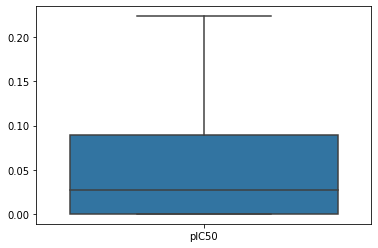

In [8]:
sns.boxplot(data = corr_, showfliers = False)
plt.show()

In [9]:
# Selection of correlated columns to Y. 
cut_off = [0, 0.03, 0.06, 0.10]

corr_against_y = list()

for number in cut_off:
    col = corr_[corr_['pIC50'] >= number]
    col = col.index.tolist()
    print(f'The length of features is {len(col)}')
    corr_against_y.append(col)

The length of features is 881
The length of features is 427
The length of features is 322
The length of features is 173


### Co-variance

In [10]:
# Removal of Covariance Columns 
# Code snippet taken from krishnaik06 https://github.com/krishnaik06/Complete-Feature-Selection

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [11]:
corr_col = list()
threshold = [0.6, 0.7, 0.8]

for thres in threshold:
    for col in corr_against_y:
        covariance = correlation(cleaned_df[col].corr(), thres)
        columns = list(covariance)
        print(f'The number of covariant features is {len(columns)} with a threshold of {thres}')
        corr_col.append(columns)
    

The number of covariant features is 484 with a threshold of 0.6
The number of covariant features is 387 with a threshold of 0.6
The number of covariant features is 294 with a threshold of 0.6
The number of covariant features is 158 with a threshold of 0.6
The number of covariant features is 453 with a threshold of 0.7
The number of covariant features is 360 with a threshold of 0.7
The number of covariant features is 276 with a threshold of 0.7
The number of covariant features is 151 with a threshold of 0.7
The number of covariant features is 401 with a threshold of 0.8
The number of covariant features is 320 with a threshold of 0.8
The number of covariant features is 247 with a threshold of 0.8
The number of covariant features is 141 with a threshold of 0.8


### Removal of Low Threshold 

In [12]:
from sklearn.feature_selection import VarianceThreshold

In [19]:
non_constant_removal = list()

In [20]:
for thres in [0.001, 0.01, 0.1]:
    for col in corr_col:
        X = cleaned_df[col]
        selector = VarianceThreshold(0.1)
        selection = selector.fit_transform(X)
        keep = X.columns[selector.get_support()]
        keep = keep.tolist()
        print(f'The Number of features after Low Var removal: {len(keep)}')
        print('---------------------------------------------------------------------')
        non_constant_removal.append(keep)

The Number of features after Low Var removal: 216
---------------------------------------------------------------------
The Number of features after Low Var removal: 190
---------------------------------------------------------------------
The Number of features after Low Var removal: 146
---------------------------------------------------------------------
The Number of features after Low Var removal: 92
---------------------------------------------------------------------
The Number of features after Low Var removal: 207
---------------------------------------------------------------------
The Number of features after Low Var removal: 181
---------------------------------------------------------------------
The Number of features after Low Var removal: 140
---------------------------------------------------------------------
The Number of features after Low Var removal: 89
---------------------------------------------------------------------
The Number of features after Low Var remov

In [22]:
final_output = corr_against_y + corr_col + non_constant_removal

In [38]:
dict_ = {}

for i in range(len(final_output)):
    dict_[i] = [final_output[i]]

In [44]:
df_feature = pd.DataFrame(dict_).transpose()
df_feature.columns = ['features']

In [50]:
df_feature.head()

,features,length
0,"[PubchemFP654, PubchemFP560, PubchemFP375, Pub...",881
1,"[PubchemFP654, PubchemFP560, PubchemFP375, Pub...",427
2,"[PubchemFP654, PubchemFP560, PubchemFP375, Pub...",322
3,"[PubchemFP654, PubchemFP560, PubchemFP375, Pub...",173
4,"[PubchemFP409, PubchemFP532, PubchemFP566, Pub...",484


In [49]:
df_feature['length'] = df_feature['features'].apply(len)

### droping Duplicate Features from selection process

In [ ]:
len(df_featu)

In [61]:
df_feature = df_feature.drop_duplicates('length', keep = 'first')

In [62]:
len(df_feature)

28